In [ ]:
#DataReader
import pickle
import numpy as np
from os.path import join
from os import listdir
import matplotlib.pyplot as plt
from tqdm import tqdm
import struct as st
class DataReader:

    def __init__(self,root_dir,type='cifar-100'):
        self.root_dir = root_dir
        self.type = type
    
    def get_dict_from_pickle(self):
            self.train_dict = unpickle(join(self.root_dir,'train'))
            self.test_dict = unpickle(join(self.root_dir,'test'))
    
    def get_train_data(self):
        if self.type == 'cifar-100':
            self.get_dict_from_pickle()
            data = np.array(self.train_dict[b'data'])
            lbls_sub = np.array(self.train_dict[b'fine_labels'])
            lbls_class = np.array(self.train_dict[b'coarse_labels'])
            return data,lbls_class,lbls_sub
        elif self.type == 'cifar-10':
            data = []
            labels = []
            print("Reading")
            for file_ in tqdm(listdir(self.root_dir)):
                if file_.split('_')[0] == 'data':
                    dict = unpickle(join(self.root_dir,file_))
                    data.extend(dict[b'data'])
                    labels.extend(dict[b'labels'])
            return np.array(data),np.array(labels),None
        elif self.type =='mnist':
            return self.read_mnist()

    def get_test_data(self):
        if self.type == 'cifar-100':
            self.get_dict_from_pickle()
            data = np.array(self.test_dict[b'data'])
            lbls_sub = np.array(self.test_dict[b'fine_labels'])
            lbls_class = np.array(self.test_dict[b'coarse_labels'])
            return data,lbls_class,lbls_sub
        elif self.type == 'cifar-10':
            data = np.empty(shape=(0,3072))
            labels = []
            for file_ in listdir(self.root_dir):
                if file_.split('_')[0] == 'test':
                    dict = unpickle(join(self.root_dir,file_))
                    data = np.vstack((data,dict[b'data']))
                    print(data[data.shape[0]-1])
                    labels.append(dict[b'labels'])
            return np.array(data),np.array(labels),None
    
    def reshape_to_plot(self,data):
        if self.type == 'mnist':
            return data.reshape(data.shape[0],28,28).astype("uint8")
        return data.reshape(data.shape[0],3,32,32).transpose(0,2,3,1).astype("uint8")

    def plot_imgs(self,in_data,n,random=False):
        data = np.array([d for d in in_data])
        data = self.reshape_to_plot(data)
        x1 = min(n//2,5)
        if x1 == 0:
            x1 = 1
        y1 = (n//x1)
        x = min(x1,y1)
        y = max(x1,y1)
        fig, ax = plt.subplots(x,y,figsize=(5,5))
        i=0
        for j in range(x):
            for k in range(y):
                if random:
                    i = np.random.choice(range(len(data)))
                ax[j][k].set_axis_off()
                ax[j][k].imshow(data[i:i+1][0])
                i+=1
        plt.show()
    
    def plot_img(self,data):
        if self.type !='mnist':
            assert data.shape == (3072,)
            data = data.reshape(1,3072)
            data = data.reshape(data.shape[0],3,32,32).transpose(0,2,3,1).astype("uint8")
        elif self.type == 'mnist':
            assert data.shape == (28*28,)
            data = data.reshape(1,28,28).astype('uint8')
        fig, ax = plt.subplots(figsize=(5,5))
        ax.imshow(data[0])
        plt.show()
    
    def read_mnist(self):  
        filename = {'images' : 'train-images-idx3-ubyte' ,'labels' : 'train-labels-idx1-ubyte'}
        labels_array = np.array([])
        data_types = {
                0x08: ('ubyte', 'B', 1),
                0x09: ('byte', 'b', 1),
                0x0B: ('>i2', 'h', 2),
                0x0C: ('>i4', 'i', 4),
                0x0D: ('>f4', 'f', 4),
                0x0E: ('>f8', 'd', 8)}
        for name in filename.keys():
            if name == 'images':
                imagesfile = open(join(self.root_dir,filename[name]),'rb')
            if name == 'labels':
                labelsfile = open(join(self.root_dir,filename[name]),'rb')
        imagesfile.seek(0)
        magic = st.unpack('>4B',imagesfile.read(4))
        if(magic[0] and magic[1])or(magic[2] not in data_types):
            raise ValueError("File Format not correct")
        nDim = magic[3]
        imagesfile.seek(4)
        nImg = st.unpack('>I',imagesfile.read(4))[0] #num of images/labels
        nR = st.unpack('>I',imagesfile.read(4))[0] #num of rows
        nC = st.unpack('>I',imagesfile.read(4))[0] #num of columns
        nBytes = nImg*nR*nC
        labelsfile.seek(8) #Since no. of items = no. of images and is already read
        images_array = 255 - np.asarray(st.unpack('>'+'B'*nBytes,imagesfile.read(nBytes))).reshape((nImg,nR,nC))
        labels_array = np.asarray(st.unpack('>'+'B'*nImg,labelsfile.read(nImg))).reshape((nImg,1))
        labels_array = [l[0] for l in labels_array]
        return images_array.reshape(60000,28*28),labels_array,None


def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [ ]:
#KMeans
import numpy as np
import copy
from tqdm import tqdm
class KMeans:
    
    def __init__(self,n_clusters=10,max_iter=50):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.loss_per_iteration = []

    def init_centroids(self):
        np.random.seed(np.random.randint(0,100000))
        self.centroids = []
        for i in range(self.n_clusters):
            rand_index = np.random.choice(range(len(self.fit_data)))
            self.centroids.append(self.fit_data[rand_index])
    
    def init_clusters(self):
        self.clusters = {'data':{i:[] for i in range(self.n_clusters)}}
        self.clusters['labels']={i:[] for i in range(self.n_clusters)}

    def fit(self,fit_data,fit_labels):
        self.fit_data = fit_data
        self.fit_labels = fit_labels
        self.predicted_labels = [None for _ in range(self.fit_data.shape[0])]
        self.init_centroids()
        self.iterations = 0
        old_centroids = [np.zeros(shape=(fit_data.shape[1],)) for _ in range(self.n_clusters)]
        while not self.converged(self.iterations,old_centroids,self.centroids):
            old_centroids = copy.deepcopy(self.centroids)
            self.init_clusters()
            for j,sample in tqdm(enumerate(self.fit_data)):
                min_dist = float('inf')
                for i,centroid in enumerate(self.centroids):
                    dist = np.linalg.norm(sample-centroid)
                    if dist<min_dist:
                        min_dist = dist
                        self.predicted_labels[j] = i
                if self.predicted_labels[j] is not None:
                        self.clusters['data'][self.predicted_labels[j]].append(sample)                    
                        self.clusters['labels'][self.predicted_labels[j]].append(self.fit_labels[j])
            self.reshape_cluster()
            self.update_centroids()
            self.calculate_loss()
            print("\nIteration:",self.iterations,'Loss:',self.loss,'Difference:',self.centroids_dist)
            self.iterations+=1
        self.calculate_accuracy()

    def update_centroids(self):
        for i in range(self.n_clusters):
            cluster = self.clusters['data'][i]
            if cluster == []:
                self.centroids[i] = self.fit_data[np.random.choice(range(len(self.fit_data)))]
            else:
                self.centroids[i] = np.mean(np.vstack((self.centroids[i],cluster)),axis=0)
    
    def reshape_cluster(self):
        for id,mat in list(self.clusters['data'].items()):
            self.clusters['data'][id] = np.array(mat)

    def converged(self,iterations,centroids,updated_centroids):
        if iterations > self.max_iter:
            return True
        self.centroids_dist = np.linalg.norm(np.array(updated_centroids)-np.array(centroids))
        if self.centroids_dist<=1e-10:
            print("Converged! With distance:",self.centroids_dist)
            return True
        return False

    def calculate_loss(self):
        self.loss = 0
        for key,value in list(self.clusters['data'].items()):
            if value is not None:
                for v in value:
                    self.loss += np.linalg.norm(v-self.centroids[key])
        self.loss_per_iteration.append(self.loss)
    
    def calculate_accuracy(self):
        self.clusters_labels = []
        self.clusters_info = []
        self.clusters_accuracy = []
        for clust,labels in list(self.clusters['labels'].items()):
            if isinstance(labels[0],(np.ndarray)):
                labels = [l[0] for l in labels]
            occur = 0
            max_label = max(set(labels), key=labels.count)
            self.clusters_labels.append(max_label)
            for label in labels:
                if label == max_label:
                    occur+=1
            acc = occur/len(list(labels))
            self.clusters_info.append([max_label,occur,len(list(labels)),acc])
            self.clusters_accuracy.append(acc)
            self.accuracy = sum(self.clusters_accuracy)/self.n_clusters
        self.labels_ = []
        for i in range(len(self.predicted_labels)):
            self.labels_.append(self.clusters_labels[self.predicted_labels[i]])
        print('[cluster_label,no_occurence_of_label,total_samples_in_cluster,cluster_accuracy]',self.clusters_info)
        print('Accuracy:',self.accuracy)

In [ ]:
!wget 'http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
#!wget 'http://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz'
!tar xzf cifar-10-python.tar.gz
#!tar xzf cifar-100-python.tar.gz

--2022-04-12 20:58:54--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz.2’

cifar-10-python.tar 100%[===================>] 162.60M  52.4MB/s    in 3.1s    

2022-04-12 20:58:58 (52.4 MB/s) - ‘cifar-10-python.tar.gz.2’ saved [170498071/170498071]



In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np

Reading


100%|██████████| 8/8 [00:00<00:00, 59.75it/s]


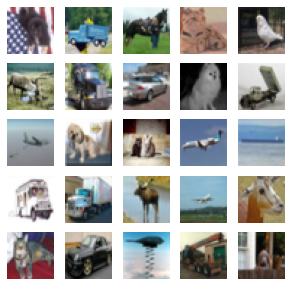

In [ ]:
data_reader = DataReader('cifar-10-batches-py','cifar-10')
tr_data, tr_class_labels, tr_subclass_labels = data_reader.get_train_data()
data_reader.plot_imgs(tr_data,25,True)

In [ ]:
kmeans = KMeans(n_clusters=10,max_iter=100)
kmeans.fit(tr_data,tr_class_labels)

50000it [00:06, 7953.11it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.



Iteration: 0 Loss: 154645765.77862346 Difference: 23377.180582782006


50000it [00:07, 6488.96it/s]



Iteration: 1 Loss: 139863791.36519876 Difference: 11884.27697812837


50000it [00:07, 6328.76it/s]



Iteration: 2 Loss: 138000124.14191347 Difference: 2200.2435596709656


50000it [00:07, 6455.76it/s]



Iteration: 3 Loss: 137443429.03690812 Difference: 859.8532973494359


50000it [00:07, 6412.59it/s]



Iteration: 4 Loss: 137206220.45288888 Difference: 517.4991732326074


50000it [00:07, 6345.21it/s]



Iteration: 5 Loss: 137085686.2355062 Difference: 346.1891709360472


50000it [00:07, 6364.60it/s]



Iteration: 6 Loss: 137016425.34562075 Difference: 251.58643771477853


50000it [00:07, 6439.59it/s]



Iteration: 7 Loss: 136969687.93310633 Difference: 199.8443005608937


50000it [00:07, 6327.69it/s]



Iteration: 8 Loss: 136935500.3878605 Difference: 167.43656384422138


50000it [00:07, 6439.41it/s]



Iteration: 9 Loss: 136910276.31900758 Difference: 142.74692303176923


50000it [00:07, 6368.74it/s]



Iteration: 10 Loss: 136890623.15323833 Difference: 126.31284191703169


50000it [00:07, 6351.09it/s]



Iteration: 11 Loss: 136877507.09806326 Difference: 110.46899523429553


50000it [00:07, 6419.86it/s]



Iteration: 12 Loss: 136866381.3689529 Difference: 91.14268435578781


50000it [00:07, 6587.60it/s]



Iteration: 13 Loss: 136857248.4553787 Difference: 90.57279574983909


50000it [00:07, 6421.88it/s]



Iteration: 14 Loss: 136851050.53003395 Difference: 77.8719318210872


50000it [00:07, 6475.71it/s]



Iteration: 15 Loss: 136846383.83955556 Difference: 67.39031592926231


50000it [00:07, 6450.90it/s]



Iteration: 16 Loss: 136842731.29499257 Difference: 60.429251758820484


50000it [00:07, 6422.35it/s]



Iteration: 17 Loss: 136839728.1004649 Difference: 58.441037475898575


50000it [00:07, 6347.47it/s]



Iteration: 18 Loss: 136836503.4775775 Difference: 57.863288842588595


50000it [00:08, 6189.02it/s]



Iteration: 19 Loss: 136833383.1801517 Difference: 58.32108980615033


50000it [00:07, 6358.17it/s]



Iteration: 20 Loss: 136831024.61335778 Difference: 57.0350629991146


50000it [00:07, 6358.26it/s]



Iteration: 21 Loss: 136829491.67843747 Difference: 52.676115177701284


50000it [00:07, 6295.38it/s]



Iteration: 22 Loss: 136828285.1631616 Difference: 48.20509352925947


50000it [00:07, 6405.14it/s]



Iteration: 23 Loss: 136827766.4424762 Difference: 42.72410132346943


50000it [00:07, 6405.00it/s]



Iteration: 24 Loss: 136826038.3966493 Difference: 40.33200006182973


50000it [00:08, 6214.61it/s]



Iteration: 25 Loss: 136823964.80951697 Difference: 41.42036749616997


50000it [00:08, 6238.11it/s]



Iteration: 26 Loss: 136821560.56930947 Difference: 44.934693199986086


50000it [00:07, 6306.48it/s]



Iteration: 27 Loss: 136819520.1060674 Difference: 48.150415003907256


50000it [00:08, 6227.59it/s]



Iteration: 28 Loss: 136817635.1187806 Difference: 42.782720411603044


50000it [00:07, 6291.95it/s]



Iteration: 29 Loss: 136815385.76402488 Difference: 45.07361290002784


50000it [00:07, 6333.92it/s]



Iteration: 30 Loss: 136812364.55186015 Difference: 48.99675873308986


50000it [00:07, 6277.66it/s]



Iteration: 31 Loss: 136809360.40273517 Difference: 54.07981392530316


50000it [00:07, 6346.24it/s]



Iteration: 32 Loss: 136805023.89564663 Difference: 55.98976110347904


50000it [00:07, 6343.57it/s]



Iteration: 33 Loss: 136800535.9589174 Difference: 57.90211897498173


50000it [00:07, 6326.75it/s]



Iteration: 34 Loss: 136796323.9303641 Difference: 56.57752451377817


50000it [00:07, 6288.36it/s]



Iteration: 35 Loss: 136792739.56780678 Difference: 54.36323845524022


50000it [00:07, 6384.56it/s]



Iteration: 36 Loss: 136788971.09342235 Difference: 56.927552061594724


50000it [00:08, 6247.23it/s]



Iteration: 37 Loss: 136784620.8876052 Difference: 56.0550708753321


50000it [00:07, 6311.13it/s]



Iteration: 38 Loss: 136780670.07267776 Difference: 58.99758963227255


50000it [00:07, 6380.09it/s]



Iteration: 39 Loss: 136778605.2871052 Difference: 51.61329899844071


50000it [00:08, 6141.33it/s]



Iteration: 40 Loss: 136776243.93922684 Difference: 43.943573841924874


50000it [00:07, 6348.82it/s]



Iteration: 41 Loss: 136774326.68706205 Difference: 42.62378018815666


50000it [00:07, 6300.92it/s]



Iteration: 42 Loss: 136772341.23839754 Difference: 37.932419889020714


50000it [00:07, 6365.15it/s]



Iteration: 43 Loss: 136770520.6189174 Difference: 35.39508787533067


50000it [00:07, 6611.45it/s]



Iteration: 44 Loss: 136769097.209286 Difference: 36.31894518062049


50000it [00:07, 6666.48it/s]



Iteration: 45 Loss: 136768060.6868495 Difference: 28.136528471757174


50000it [00:07, 6667.07it/s]



Iteration: 46 Loss: 136767311.11531654 Difference: 25.15083288488031


50000it [00:07, 6755.89it/s]



Iteration: 47 Loss: 136766253.91275272 Difference: 24.83292382328458


50000it [00:07, 6737.01it/s]



Iteration: 48 Loss: 136765600.41155803 Difference: 26.24320317676359


50000it [00:07, 6729.78it/s]



Iteration: 49 Loss: 136764342.58452082 Difference: 23.379749517235787


50000it [00:07, 6730.65it/s]



Iteration: 50 Loss: 136762859.10586318 Difference: 23.036245340241244
[cluster_label,no_occurence_of_label,total_samples_in_cluster,cluster_accuracy] [[8, 1328, 3925, 0.338343949044586], [0, 1072, 3276, 0.32722832722832723], [5, 950, 5305, 0.17907634307257306], [6, 1222, 7321, 0.1669170878295315], [6, 1199, 5369, 0.2233190538275284], [2, 1080, 6394, 0.16890835157960588], [4, 895, 4572, 0.1957567804024497], [9, 1659, 6006, 0.2762237762237762], [0, 1082, 3748, 0.2886872998932764], [9, 761, 4084, 0.18633692458374143]]
Accuracy: 0.2350797893685396
